In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Import Libraries

In [25]:
import torch # pytorch
import torch.nn as nn
import torch.optim as optim # Optimizer
from torch.optim import lr_scheduler # Learning rate scheduler
import torch.backends.cudnn as cudnn # GPU power 
import numpy as np # For numpy arrays 
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt # For visualization
import time # To get the time of the training
import os # To go inside the folders of the dataset
from PIL import Image # To load a RGB image
from tempfile import TemporaryDirectory #To create a temporary drive
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns # For nicer confusion matrix plots
import pandas as pd

In [3]:
cudnn.benchmark = True # Optimize GPU performance
plt.ion() # Plot in real-time

### Data Transformations

In [4]:
# Define transformations for the images
# Training transforms: Include data augmentation
data_transforms = {
'train' : transforms.Compose([
    transforms.RandomResizedCrop(224), # Randomly crop and resize to 224x224. Creating a ResNet. Improves accuracy
    transforms.RandomHorizontalFlip(), # Randomly flip image horizontally. Improves accuracy
    transforms.ToTensor(),             # Convert image to PyTorch Tensor. Scale pixel values from [0, 255] to [0.0, 1.0]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 3 channels -> Normalize RGB values with ImageNet stats
]),

# Validation and Test transforms: Only resize, convert to tensor, and normalize
'val' : transforms.Compose([
    transforms.Resize(256),     # Resize shorter side to 256
    transforms.CenterCrop(224), # Crop center 224x224
    transforms.ToTensor(),      # Convert image to PyTorch Tensor. Scale pixel values [0, 255] to [0.0, 1.0]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 3 channels -> Normalize with ImageNet stats
]),
}

### Load Datasets

In [5]:
data_dir = r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project  1\Animal_Image_Classifier\1_data' # data set location

In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']} # Loads images and applies transforms from folders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=6, # Use 4 threads
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']} # Batches and shuffles data for training/validation
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']} # 	Stores number of images in each set
class_names = image_datasets['train'].classes # Lists class names from the dataset

In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu" # Check if any hardware accelerator is available
print(f"Using {device} device") # Print out the hardware accelerator

Using cpu device


### Verify the Data Loading

In [8]:
def imshow(inp, title=None):
    """Display image for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0)) # Converts from PyTorch tensor to NumPy array
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Un-normalize the data
    inp = np.clip(inp, 0, 1) # Ensures all values are within valid image range [0, 1] for display
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # Allows time for the plot window to refresh

In [9]:
# Take a batch of training data
inputs, classes = next(iter(dataloaders['train']))

In [10]:
# Create a grid from batch
out = torchvision.utils.make_grid(inputs)

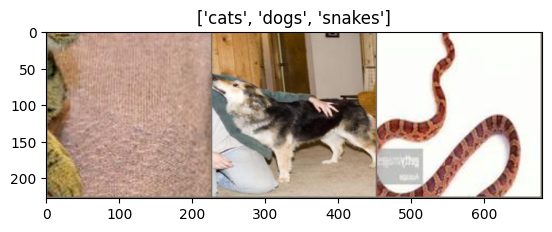

In [11]:
# Sample one image from each class
class_images = {}
for class_name in class_names:
    # Find indices for the current class
    indices = [i for i, label in enumerate(image_datasets['train'].targets) if label == class_names.index(class_name)]
    # Get one image from the indices
    img, label = image_datasets['train'][indices[0]]  # Take the first image of the class
    class_images[class_name] = img

# Create a grid for display
images = [class_images[class_name] for class_name in class_names]
out = torchvision.utils.make_grid(images)
imshow(out, title=class_names)

### Model Training

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    since = time.time()

    models_dir = r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project  1\Animal_Image_Classifier\2_models'
    os.makedirs(models_dir, exist_ok=True)  # Create models directory if it doesn't exist
    print(f"Created/Using models directory: {models_dir}")  # Debug print
    best_model_params_path = os.path.join(models_dir, 'best_model.pth')
    final_model_params_path = os.path.join(models_dir, 'final_model.pth')

    torch.save(model.state_dict(), final_model_params_path)  # Save initial state
    best_acc = 0.0
    train_acc = 0.0
    val_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_acc = epoch_acc
            else:
                val_acc = epoch_acc

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Final Training Acc: {train_acc:.4f}')
    print(f'Final Validation Acc: {val_acc:.4f}')
    print(f'Best Validation Acc: {best_acc:.4f}')
    print(f'Model saved to: {best_model_params_path} and {final_model_params_path}')

    model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing Model Predictions

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training # Save current training state
    model.eval() # Set model to evaluation mode
    images_so_far = 0 # Counter for how many images we've visualized
    fig = plt.figure() # Start a new matplotlib figure

    with torch.no_grad(): # Disables gradient tracking. Thus, we save the memory and computation since the gradients are not needed for inference
        for i, (inputs, labels) in enumerate(dataloaders['val']): # Iterates through validation set batches
            # Move data to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs) # Pass inputs through the model
            _, preds = torch.max(outputs, 1) # stores the predicted class index for each image

            for j in range(inputs.size()[0]):
                images_so_far += 1 # For each image in the batch increment the no. of images shown so far
                # Display the image
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off') # Turn off axis markings and range values
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images: # Stop visualizing when enough no of images are shown
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training) # Restore the model’s original mode

### Finetune CNN

In [14]:
model_ft = models.resnet18(weights='IMAGENET1K_V1') # Load the ResNet-18 model
# Replace the final layer
num_ftrs = model_ft.fc.in_features

# Get the number of classes from your dataset
# Make sure this line is executed BEFORE this cell, e.g., in Cell 6 or earlier
# if it's not already globally available.
# From Cell 6: class_names = image_datasets['train'].classes
# So, we can directly use:
num_classes = len(class_names) # This should be 3

model_ft.fc = nn.Linear(num_ftrs, num_classes) # Changed from 2 to num_classes

# Move the model to device
model_ft = model_ft.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the Optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Define Learning Rate Scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Training and Evaluating

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Created/Using models directory: D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project  1\Animal_Image_Classifier\2_models
Epoch 0/1
----------
train Loss: 0.4333 Acc: 0.8383
val Loss: 0.0627 Acc: 0.9783

Epoch 1/1
----------
train Loss: 0.3619 Acc: 0.8625
val Loss: 0.0617 Acc: 0.9783

Training complete in 22m 4s
Final Training Acc: 0.8625
Final Validation Acc: 0.9783
Best Validation Acc: 0.9783
Model saved to: D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project  1\Animal_Image_Classifier\2_models\best_model.pth and D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project  1\Animal_Image_Classifier\2_models\final_model.pth


### Visualize the Output

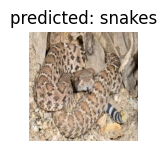

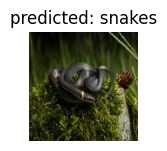

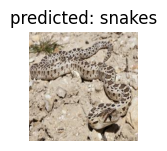

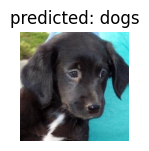

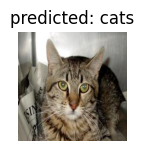

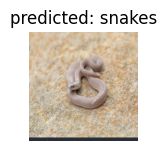

In [16]:
visualize_model(model_ft)

### Transfer Learning (Feature Extraction)

In [17]:
# Load the ResNet-18 model with pre-trained ImageNet weights
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Freezes all parameters in the network (except for the newly replaced final layer)
for param in model_conv.parameters():
    param.requires_grad = False

# Replace the final layer
num_ftrs = model_conv.fc.in_features

# MODIFICATION: Ensure the output features match the number of classes in your dataset.
# We previously established you have 3 classes ('cats', 'dogs', 'snakes').
# Make sure 'num_classes' is accessible (it should be from Cell 6, or redefine it here if needed: num_classes = len(class_names))
num_classes = len(class_names) # Assuming class_names is already defined from Cell 6

model_conv.fc = nn.Linear(num_ftrs, num_classes) # Corrected to use num_classes

# Move the model to device
model_conv = model_conv.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the Optimizer
# Only parameters of the new final layer (which requires_grad is True) will be optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Define Learning Rate Scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Training & Evaluate

In [18]:
# Call the train_model function to train the 'model_conv' (feature extractor)
# using the defined criterion, optimizer, scheduler, and number of epochs.
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=2)

Created/Using models directory: D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project  1\Animal_Image_Classifier\2_models
Epoch 0/1
----------
train Loss: 0.4202 Acc: 0.8171
val Loss: 0.0537 Acc: 0.9833

Epoch 1/1
----------
train Loss: 0.3326 Acc: 0.8750
val Loss: 0.0465 Acc: 0.9850

Training complete in 8m 16s
Final Training Acc: 0.8750
Final Validation Acc: 0.9850
Best Validation Acc: 0.9850
Model saved to: D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project  1\Animal_Image_Classifier\2_models\best_model.pth and D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project  1\Animal_Image_Classifier\2_models\final_model.pth


### Visualize the Output

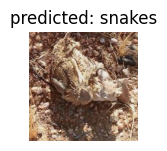

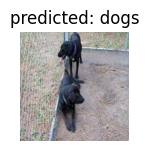

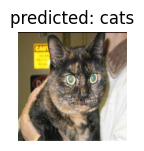

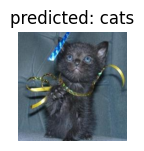

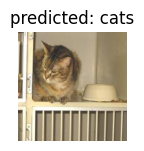

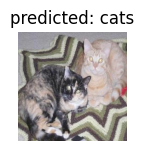

In [19]:
# Call the visualize_model function to display predictions on a few validation images.
# This assumes model_conv has been successfully trained and loaded with weights
# from the previous training step.
visualize_model(model_conv)

# Turn off interactive plotting mode and show the plot window.
# The window will remain open until manually closed.
plt.ioff()
plt.show()

### Inference

In [20]:
def visualize_model_predictions(model, img_path):
    """
    Loads a single image from a given path, preprocesses it, makes a prediction
    using the provided model, and displays the image with its predicted class.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        img_path (str): The file path to the image to visualize.
    """
    was_training = model.training  # Saves whether the model was in training mode
    model.eval()  # Sets the model to evaluation mode

    # Load and preprocess the image
    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)  # Adds a batch dimension, converting shape from [C, H, W] to [1, C, H, W]
    # Move the image to device
    img = img.to(device)

    with torch.no_grad():  # Disables gradient calculation for inference
        # Perform the prediction
        outputs = model(img)
        _, preds = torch.max(outputs, 1) # Get the predicted class index

        # Display the image with prediction
        # Using subplot(1,1,1) for a single image might be more conventional
        # than (2,2,1) if only one image is intended per call, but both work.
        fig = plt.figure() # Create a new figure for this single image
        ax = fig.add_subplot(1, 1, 1) # Simpler subplot for a single image
        ax.axis('off')  # Turn off axis markings and range values
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

    model.train(mode=was_training)  # Restore the model’s original mode
    plt.show() # Display the figure created within this function

**We restore the model's original mode (train or eval) so that it keeps working correctly after we're done showing predictions.**

### Get prediction for new data

#### Fine tuned model

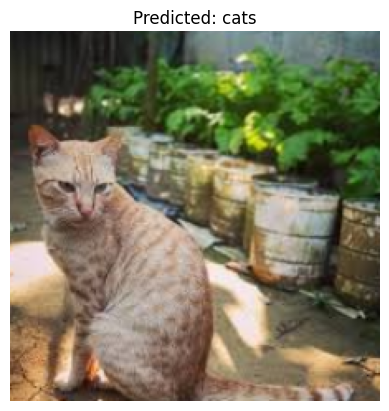

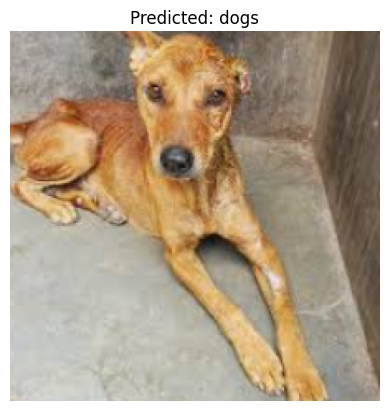

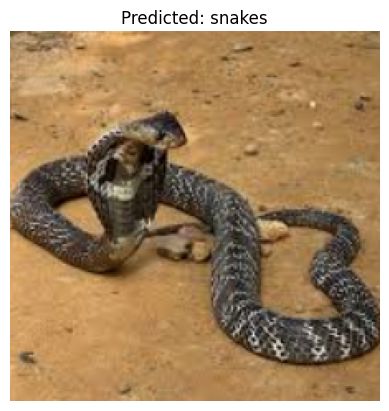

In [ ]:
visualize_model_predictions(
    model_ft,
    img_path=r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project  1\Animal_Image_Classifier\1_data\test\1001.jpg'
)

visualize_model_predictions(
    model_ft,
    img_path=r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project  1\Animal_Image_Classifier\1_data\test\1002.jpg'
)

visualize_model_predictions(
    model_ft,
    img_path=r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project  1\Animal_Image_Classifier\1_data\test\1003.jpg'
)

plt.ioff()
plt.show()

#### Transfer learning model

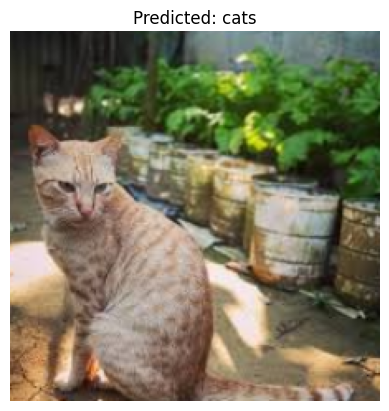

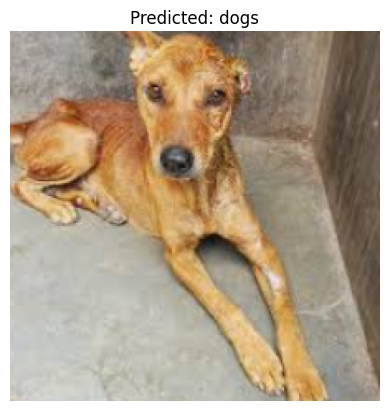

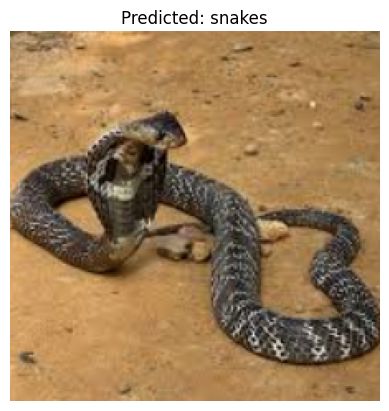

In [22]:

# Transfer Learning model
visualize_model_predictions(
    model_conv,
    img_path=r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project  1\Animal_Image_Classifier\1_data\test\1001.jpg'
)
visualize_model_predictions(
    model_conv,
    img_path=r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project  1\Animal_Image_Classifier\1_data\test\1002.jpg'
)
visualize_model_predictions(
    model_conv,
    img_path=r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project  1\Animal_Image_Classifier\1_data\test\1003.jpg'
)

plt.ioff()
plt.show()

### Generate Confusion Matrix and Classification Report

Created/Using results directory: D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project 1\Animal_Image_Classifier\4_results

--- Val Set Evaluation ---

Classification Report:
               precision    recall  f1-score   support

        cats     0.9845    0.9500    0.9669       200
        dogs     0.9563    0.9850    0.9704       200
      snakes     0.9950    1.0000    0.9975       200

    accuracy                         0.9783       600
   macro avg     0.9786    0.9783    0.9783       600
weighted avg     0.9786    0.9783    0.9783       600

Classification report saved to: D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project 1\Animal_Image_Classifier\4_results\val_classification_report.txt
Confusion matrix image saved to: D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project 1\Animal_Image_Classifier\4_results\val_confusion_matrix.png


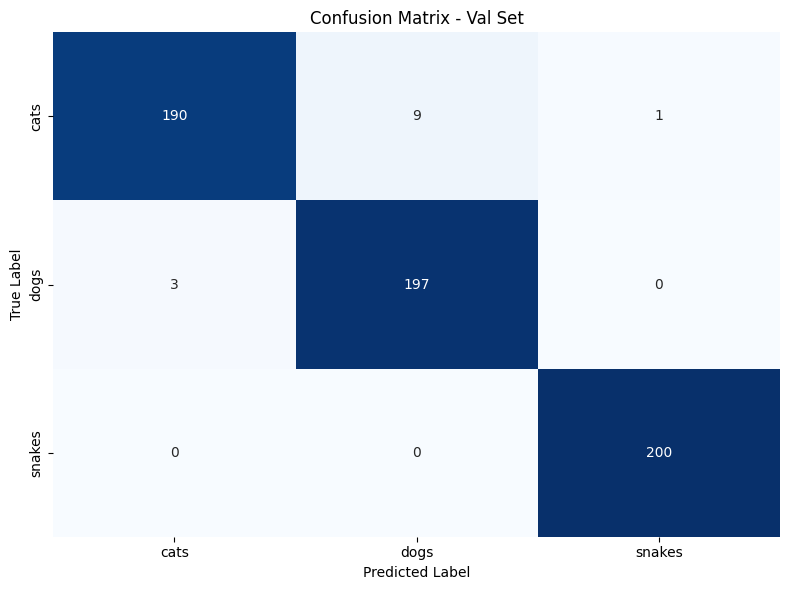

Created/Using results directory: D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project 1\Animal_Image_Classifier\4_results

--- Val Set Evaluation ---

Classification Report:
               precision    recall  f1-score   support

        cats     0.9704    0.9850    0.9777       200
        dogs     0.9848    0.9750    0.9799       200
      snakes     1.0000    0.9950    0.9975       200

    accuracy                         0.9850       600
   macro avg     0.9851    0.9850    0.9850       600
weighted avg     0.9851    0.9850    0.9850       600

Classification report saved to: D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project 1\Animal_Image_Classifier\4_results\val_classification_report.txt
Confusion matrix image saved to: D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project 1\Animal_Image_Classifier\4_results\val_confusion_matrix.png


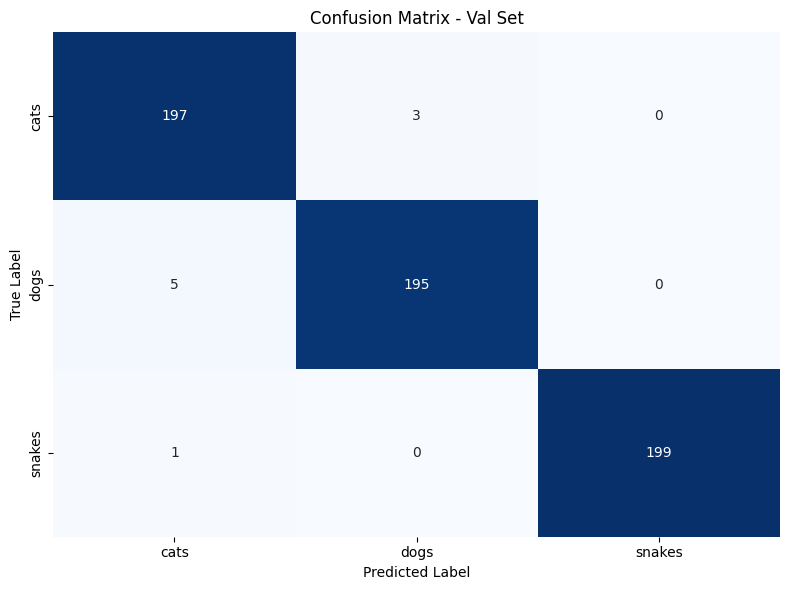

In [26]:
def evaluate_model_performance(model, dataloaders_dict, class_names, device, phase='val'):
    """
    Evaluates the model's performance on a given dataset (validation or test)
    and prints the classification report and confusion matrix, also saving them.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        dataloaders_dict (dict): Dictionary of DataLoaders (e.g., {'val': val_dataloader}).
        class_names (list): List of class names.
        device (torch.device): The device (CPU or GPU) to run inference on.
        phase (str): The phase being evaluated, typically 'val' or 'test'.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    # Define the results directory
    results_dir = r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.14 - Project 1\Animal_Image_Classifier\4_results'
    os.makedirs(results_dir, exist_ok=True) # Create the directory if it doesn't exist
    print(f"Created/Using results directory: {results_dir}")

    with torch.no_grad():
        # Using dataloaders_dict[phase] to get the correct dataloader
        for inputs, labels in dataloaders_dict[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\n--- {phase.capitalize()} Set Evaluation ---")

    # Classification Report
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    print("\nClassification Report:\n", report)

    # Save Classification Report
    report_path = os.path.join(results_dir, f'{phase}_classification_report.txt')
    with open(report_path, 'w') as f:
        f.write(report)
    print(f"Classification report saved to: {report_path}")

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_preds)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {phase.capitalize()} Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

    # Save Confusion Matrix Image FIRST
    cm_image_path = os.path.join(results_dir, f'{phase}_confusion_matrix.png')
    plt.savefig(cm_image_path)
    print(f"Confusion matrix image saved to: {cm_image_path}")

    plt.show() # Then display the plot
    plt.close() # Then close the plot to free up memory

# Call the evaluation function for the fine-tuned model
# Make sure 'dataloaders', 'class_names', and 'device' are defined from previous cells.
evaluate_model_performance(model_ft, dataloaders, class_names, device, phase='val')

# Call the evaluation function for the transfer learning model
evaluate_model_performance(model_conv, dataloaders, class_names, device, phase='val')

plt.ioff()
plt.show() # This plt.show() will display any remaining plots if plt.close() wasn't called